## Imports and Utils

In [ ]:
import torch
import os
import cv2
import random
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
import sys

from lit_model import lit_gazetrack_model

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

root = os.environ['SLURM_TMPDIR']

In [ ]:
import numpy as np
from colorspacious import cspace_convert

def get_colors(num_colors):
    hues = np.linspace(0, 360, num_colors, endpoint=False)
    lab_colors = np.column_stack([
        50 * np.ones(num_colors),
        80 * np.cos(np.deg2rad(hues)),
        80 * np.sin(np.deg2rad(hues))
    ])
    lab_colors[:, 0] += np.random.uniform(-5, 5, num_colors)
    chroma = np.sqrt(lab_colors[:, 1]**2 + lab_colors[:, 2]**2)
    chroma += np.random.uniform(-10, 10, num_colors)
    lab_colors[:, 1] *= chroma / np.sqrt(lab_colors[:, 1]**2 + lab_colors[:, 2]**2)
    lab_colors[:, 2] *= chroma / np.sqrt(lab_colors[:, 1]**2 + lab_colors[:, 2]**2)
    rgb_colors = cspace_convert(lab_colors, "CAM02-UCS", "sRGB1")


    rgb_colors = np.clip(rgb_colors, 0, 1)

    return rgb_colors

def euc(a, b):
    return np.linalg.norm(a - b, axis=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

class ImagePlotter:
    def __init__(self):
        self.fig = None
        self.axes = None

    @staticmethod
    def make_img(fname):
        imgs = [plt.imread(f) for f in np.random.choice(glob(f"{fname}*.jpg"), 4, replace=False)]
        return np.block([[imgs[0], imgs[1]], [imgs[2], imgs[3]]]) / 255.

    @staticmethod
    def _assign_colors(gt, pts, c):
        cols = np.zeros((len(gt), 3))
        for i, pt in enumerate(pts):
            mask = np.all(gt == pt, axis=1)
            cols[mask] = c[i]
        return cols

    @staticmethod
    def _calculate_centroids(gt, preds, pts):
        cents = np.zeros_like(preds)
        for pt in pts:
            mask = np.all(gt == pt, axis=1)
            cents[mask] = np.mean(preds[mask], axis=0)
        return cents

    def plot_pts(self, fname, gt, preds, pts, c, title, cent=False):
        self.fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

        ax1.imshow(self.make_img(fname))

        cols = self._assign_colors(gt, pts, c)
        cents = self._calculate_centroids(gt, preds, pts) if cent else None

        ax2.set_title(title)
        ax2.grid(color='gray', linestyle='dashed')
        ax2.scatter(0, 0, marker='*', s=200, label="Camera")
        ax2.scatter(preds[:, 0], preds[:, 1], c=cols, s=10, label="Model predictions")
        ax2.scatter(gt[:, 0], gt[:, 1], c=cols, marker='+', s=200, label="Ground truth locations")
        if cent:
            ax2.scatter(cents[:, 0], cents[:, 1], c=cols, marker='1', s=100, label="Predictions centroid")

        ax2.set_xlabel('distance from the camera at origin in x direction (cm)')
        ax2.set_ylabel('distance from the camera at origin in y direction (cm)')
        ax2.set_xlim(-2.5, 4)
        ax2.set_ylim(-13, 0.2)
        ax2.legend()
        ax2.set_aspect('equal')


        

    def plot_comp(self, gt, preds1, preds2, pts, c, title=['', ''], cent='none', lines=False):
        self.fig, self.axes = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(22, 11))
        self.fig.patch.set_facecolor('white')

        cols = self._assign_colors(gt, pts, c)
        cents1 = self._calculate_centroids(gt, preds1, pts) if cent in ['both', 'only'] else None
        cents2 = self._calculate_centroids(gt, preds2, pts) if cent in ['both', 'only'] else None

        for ax, preds, cents, title in zip(self.axes[:2], [preds1, preds2], [cents1, cents2], title):
            self._plot_single_comp(ax, gt, preds, cents, cols, title, cent)

        if lines:
            self._plot_lines(gt, preds1, preds2, cents1, cents2, cols, cent)

    def _plot_single_comp(self, ax, gt, preds, cents, cols, title, cent):
        ax.set_title(title)
        ax.grid(color='gray', linestyle='dashed')
        ax.scatter(0, 0, marker='*', s=200, label='Camera')
        if cent in ['none', 'both']:
            ax.scatter(preds[:, 0], preds[:, 1], c=cols, s=10, label="Model Predictions")
        ax.scatter(gt[:, 0], gt[:, 1], c=cols, marker='+', s=200, label="Ground Truths")
        if cent in ['both', 'only']:
            ax.scatter(cents[:, 0], cents[:, 1], c=cols, marker='1', s=70, label="Prediction Centroids")
        ax.set_xlabel('distance from the camera at origin in x direction (cm)')
        ax.set_ylabel('distance from the camera at origin in y direction (cm)')
        ax.set_xlim(-3, 5)
        ax.set_ylim(-12, 0.5)
        ax.set_aspect('equal')
        ax.legend(loc=3)

    def _plot_lines(self, gt, preds1, preds2, cents1, cents2, cols, cent):
        ax = self.axes[2]
        ax.set_title("Movement of points")
        ax.grid(color='gray', linestyle='dashed')
        ax.scatter(0, 0, marker='*', s=200, label='Camera')
        if cent in ['none', 'both']:
            ax.scatter(preds1[:, 0], preds1[:, 1], c=cols, s=10, label="Base Model Predictions")
            ax.scatter(preds2[:, 0], preds2[:, 1], c=cols, marker="p", s=30, label="SVR Predictions")
            ax.plot([preds1[:, 0], preds2[:, 0]], [preds1[:, 1], preds2[:, 1]], c=cols, linewidth=0.5)
        if cent in ['both', 'only']:
            ax.scatter(cents1[:, 0], cents1[:, 1], c=cols, marker='1', s=70, label="Base Model Prediction Centroids")
            ax.scatter(cents2[:, 0], cents2[:, 1], c=cols, marker='p', s=70, label="SVR Prediction Centroids")
            ax.plot([cents1[:, 0], cents2[:, 0]], [cents1[:, 1], cents2[:, 1]], c=cols, linewidth=0.5)
        ax.scatter(gt[:, 0], gt[:, 1], c=cols, marker='+', s=200)
        ax.set_xlabel('distance from the camera at origin in x direction (cm)')
        ax.set_ylabel('distance from the camera at origin in y direction (cm)')
        ax.set_aspect('equal')
        ax.legend(loc=3)

    def show(self):
        plt.show()



In [ ]:
def train_affine(file, avg=False):
    file = file.replace('test', 'train')

    dataset = gazetrack_dataset(file, phase='test', v=False)
    loader = DataLoader(dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

    preds, gt = [], []
    for j in loader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = list(model(leye, reye, kps).cpu().detach().numpy())
        preds = preds+pred

        gt.extend(target.cpu().detach().numpy())

    gt = np.array(gt)
    preds = np.array(preds)
    cent = np.zeros_like(preds)

    calib_preds = []
    calib_gt = []

    if(avg):
        for i in np.unique(dot_nums):
            calib_preds.append(np.mean(preds[np.where(dot_nums==i)], axis=0))
            cent[np.where(dot_nums==i)] = np.mean(preds[np.where(dot_nums==i)], axis=0)
            calib_gt.append(np.mean(gt[np.where(dot_nums==i)], axis=0))
        calib_preds = np.array(calib_preds)
        calib_gt = np.array(calib_gt)
    else:
        calib_preds = preds.copy()
        calib_gt = gt.copy()

    cent = np.array(cent)
    trans = cv2.estimateAffine2D(calib_preds, calib_gt, method=cv2.RANSAC)[0]
    return trans, cent

def comp_pred_test(fname, avg=True, ct = False):
    trans, cent = train_affine(fname, avg)

    f = fname.replace('train', 'test')
    if(ct):
        f = fname
    test_dataset = gazetrack_dataset(f, phase='test', v=False)
    test_dataloader = DataLoader(test_dataset, batch_size=256, num_workers=10, pin_memory=False, shuffle=False,)

    preds_pre, preds_final, gt = [], [], []
    for j in test_dataloader:
        leye, reye, kps, target = j[1].cuda(), j[2].cuda(), j[3].cuda(), j[4].cuda()

        with torch.no_grad():
            pred = model(leye, reye, kps)

        pred = pred.cpu().detach().numpy()
        preds_pre.extend(pred)
        gt.extend(target.cpu().detach().numpy())

    preds_pre = np.array(preds_pre)

    preds_final = np.dot(trans[:,0:2], preds_pre.T).T + trans[:,2]

    preds_pre = np.array(preds_pre)
    preds_final = np.array(preds_final)
    pts = np.unique(gt, axis=0)

    c = get_colors(len(pts))
    random.shuffle(c)

    gt = np.array(gt)
    dist_pre = euc(preds_pre, gt)
    dist_final = euc(preds_final, gt)

    out = [dist_pre, dist_final, gt, preds_pre, preds_final, pts, c, cent]

    return out

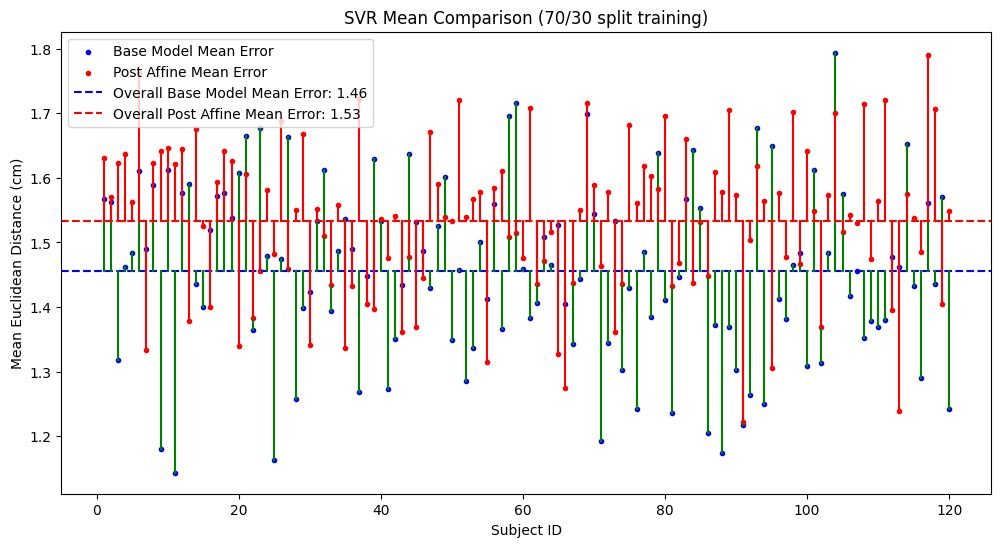

In [4]:
mean_errs_pre = []
mean_errs_final = []
for i in affine_out:
    mean_errs_pre.append(np.mean(affine_out[i][0]))
    mean_errs_final.append(np.mean(affine_out[i][1]))

plt.figure(figsize=(15,10))
plt.title('SVR Mean Comparison (70/30 split training)')
ctr = 0
plt.hlines(y=np.mean(mean_errs_pre), xmin=0, xmax=len(mean_errs_pre), color='b', linestyles='dashed', label="Overall Base Model Mean Error: "+str(np.round(np.mean(mean_errs_pre), 3))+" cm")
plt.hlines(y=np.median(mean_errs_final), xmin=0, xmax=len(mean_errs_pre), color='k', linestyles='dashed', label="Overall Post Affine Mean Error: "+str(np.round(np.mean(mean_errs_final), 3))+" cm")
for i in range(len(mean_errs_pre)):
    if(mean_errs_final[i]<= mean_errs_pre[i]):
        plt.vlines(x=ctr, ymin=mean_errs_final[i], ymax=mean_errs_pre[i], colors='green')
    else:
        plt.vlines(x=ctr, ymin=mean_errs_pre[i], ymax=mean_errs_final[i], colors='red')
    ctr+=1
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_pre, s=15, label="Base Model Mean Error", color='b')
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_final, s=15, label="Post Affine Mean Error", color='black')



plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance (cm)')
plt.ylim(0)
plt.legend()
plt.show()

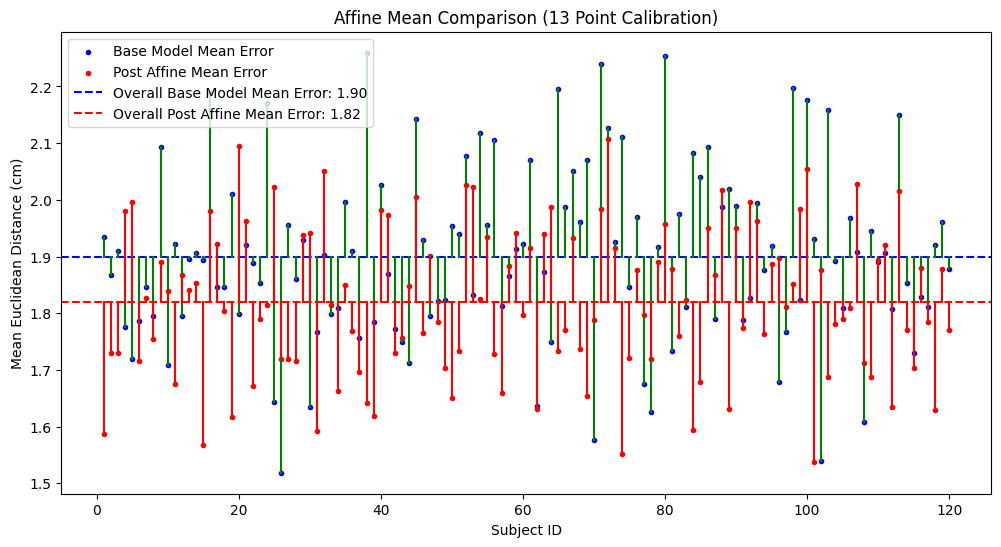

In [2]:
mean_errs_pre = []
mean_errs_final = []
for i in affine_out:
    mean_errs_pre.append(np.mean(affine_out[i][0]))
    mean_errs_final.append(np.mean(affine_out[i][1]))

plt.figure(figsize=(15,10))
plt.title('Affine Mean Comparison (13 Point Calibration)')
ctr = 0
plt.hlines(y=np.mean(mean_errs_pre), xmin=0, xmax=len(mean_errs_pre), color='b', linestyles='dashed', label="Overall Base Model Mean Error: "+str(np.round(np.mean(mean_errs_pre), 3))+" cm")
plt.hlines(y=np.median(mean_errs_final), xmin=0, xmax=len(mean_errs_pre), color='k', linestyles='dashed', label="Overall Post Affine Mean Error: "+str(np.round(np.mean(mean_errs_final), 3))+" cm")
for i in range(len(mean_errs_pre)):
    if(mean_errs_final[i]<= mean_errs_pre[i]):
        plt.vlines(x=ctr, ymin=mean_errs_final[i], ymax=mean_errs_pre[i], colors='green')
    else:
        plt.vlines(x=ctr, ymin=mean_errs_pre[i], ymax=mean_errs_final[i], colors='red')
    ctr+=1
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_pre, s=15, label="Base Model Mean Error", color='b')
plt.scatter([i for i in range(len(mean_errs_pre))], mean_errs_final, s=15, label="Post Affine Mean Error", color='black')



plt.xlabel('Subject id')
plt.ylabel('Mean Euclidean Distance (cm)')
plt.ylim(0)
plt.legend()

  0%|          | 0/10 [00:00<?, ?it/s]

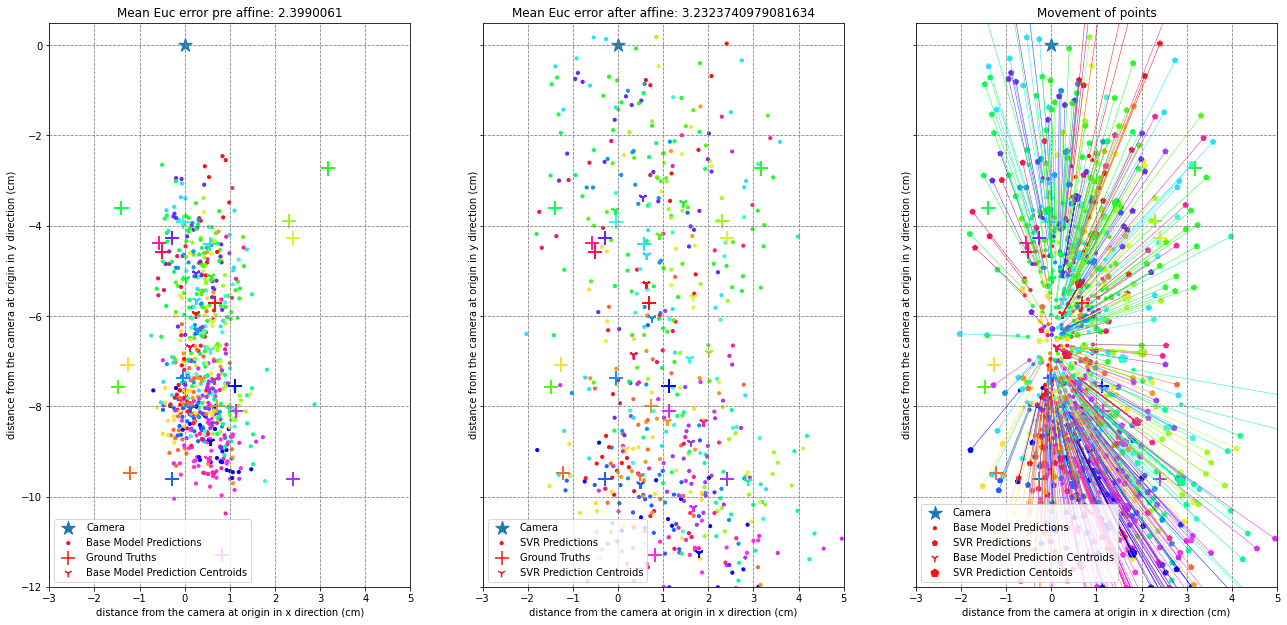

 10%|█         | 1/10 [00:01<00:12,  1.40s/it]

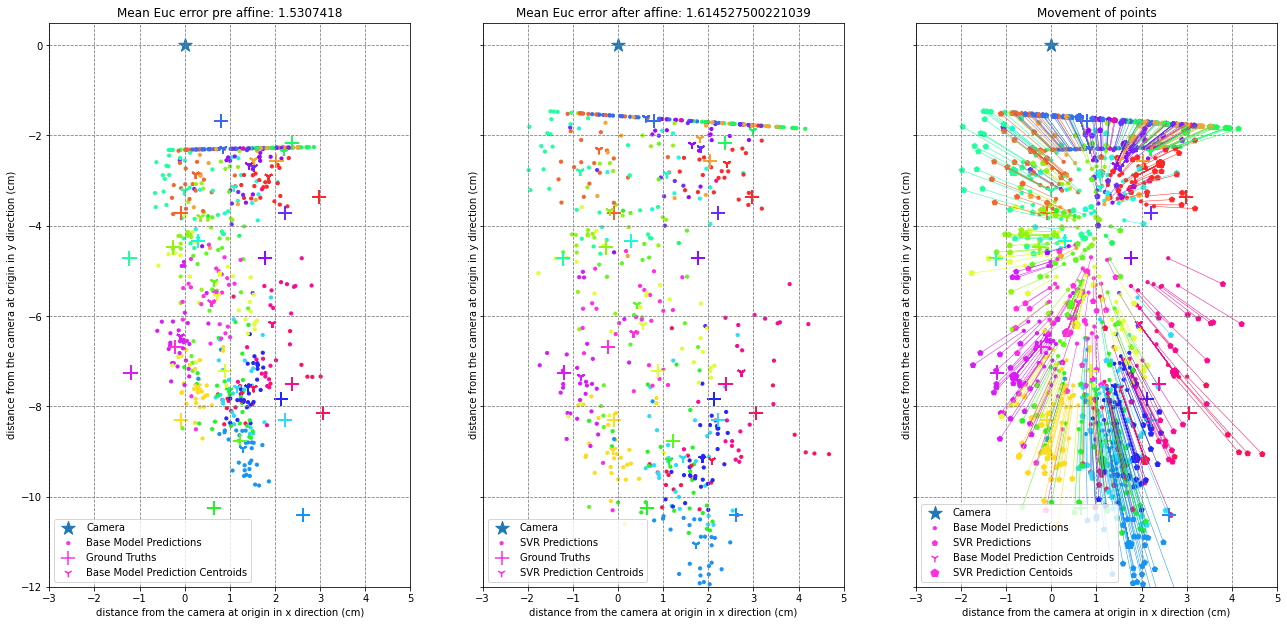

 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

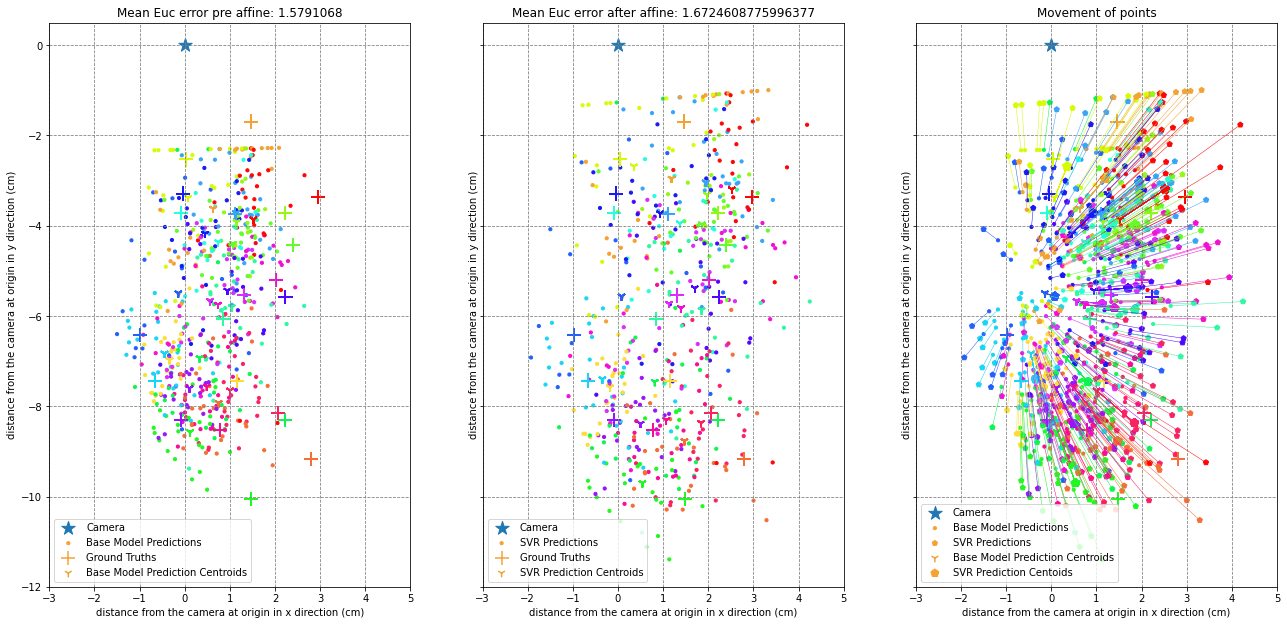

 30%|███       | 3/10 [00:04<00:09,  1.33s/it]

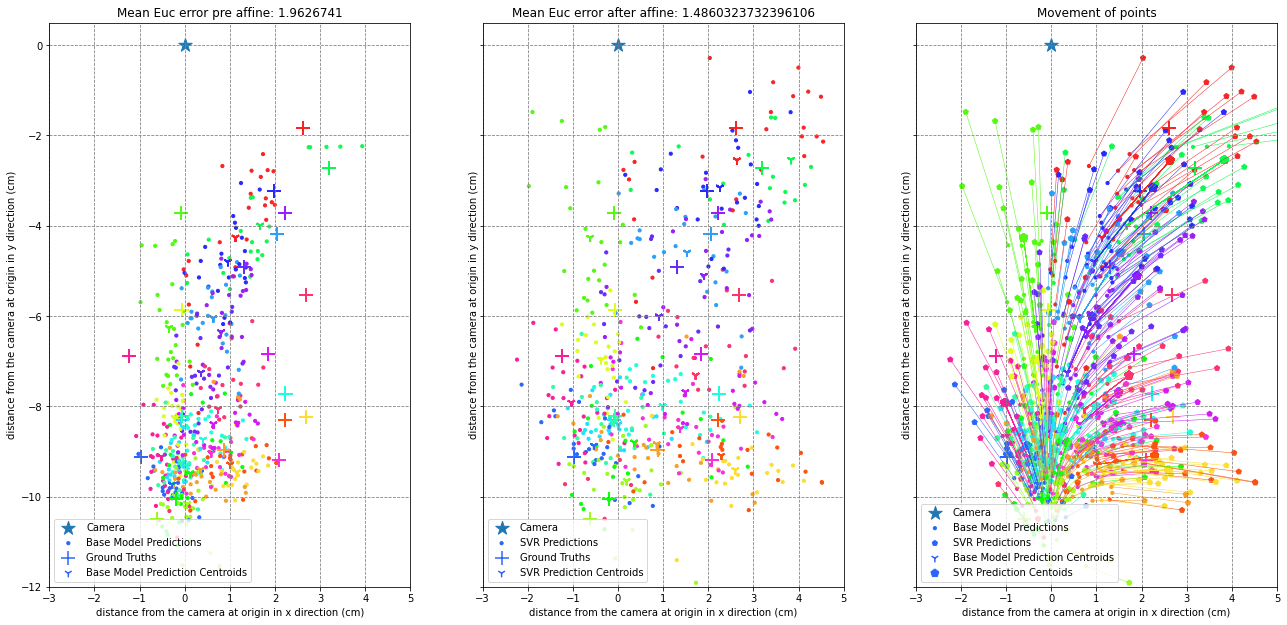

 40%|████      | 4/10 [00:05<00:07,  1.30s/it]

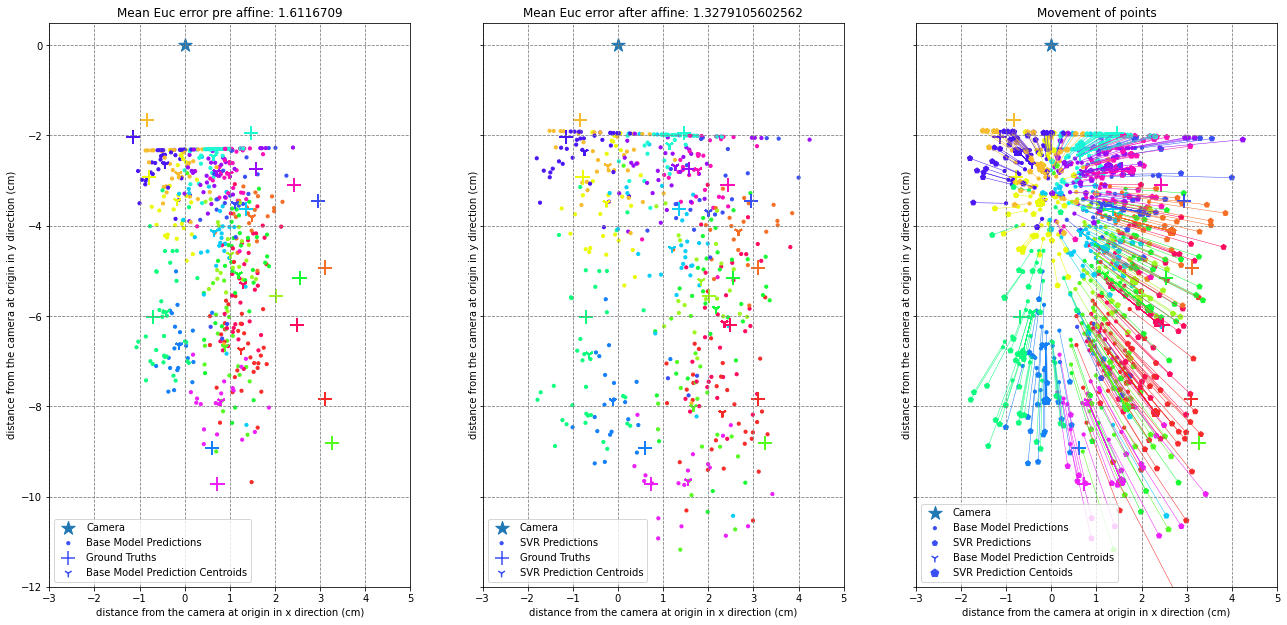

 50%|█████     | 5/10 [00:06<00:06,  1.29s/it]

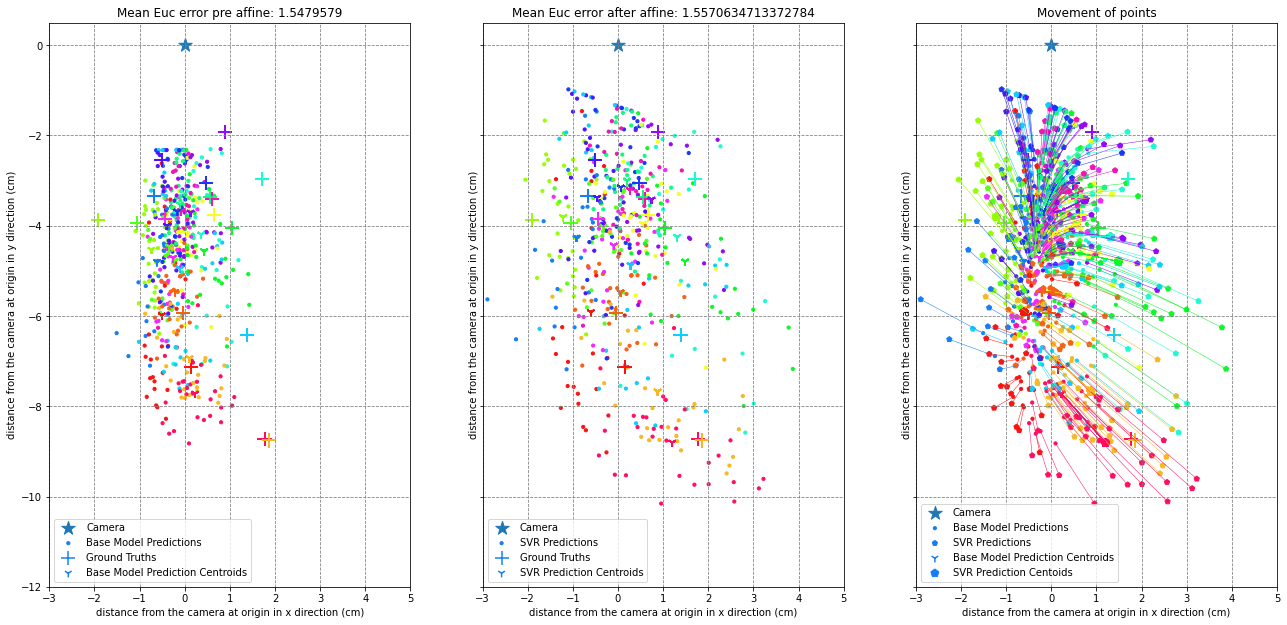

 60%|██████    | 6/10 [00:07<00:05,  1.27s/it]

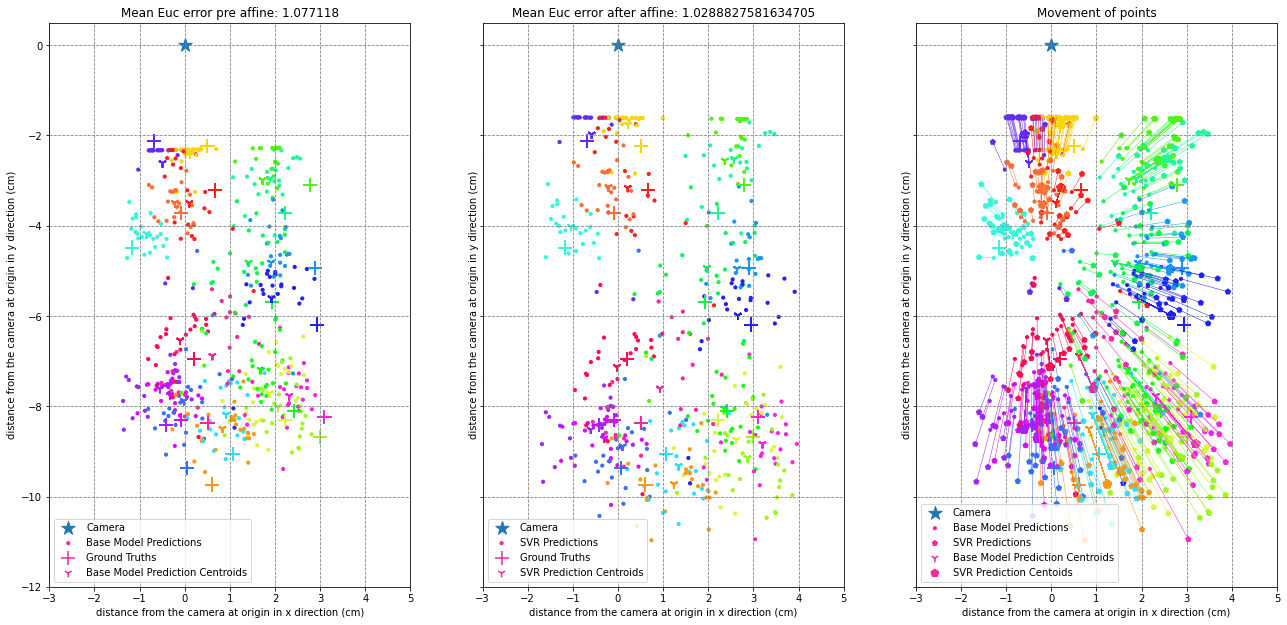

 70%|███████   | 7/10 [00:11<00:06,  2.22s/it]

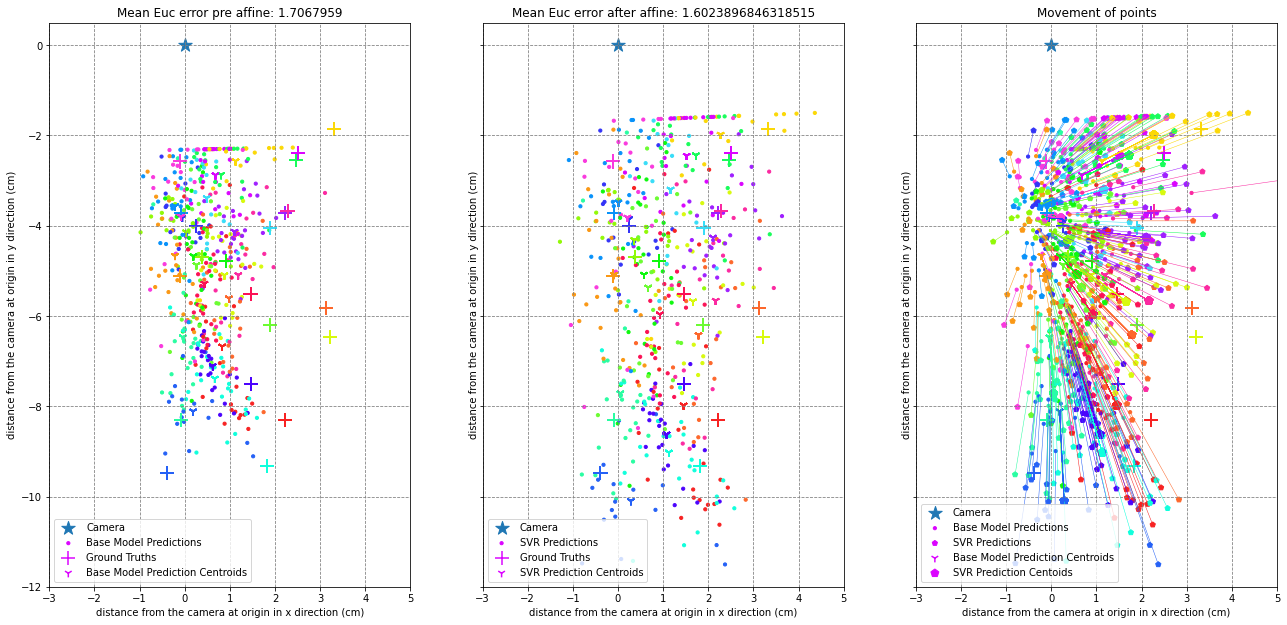

 80%|████████  | 8/10 [00:13<00:03,  1.94s/it]

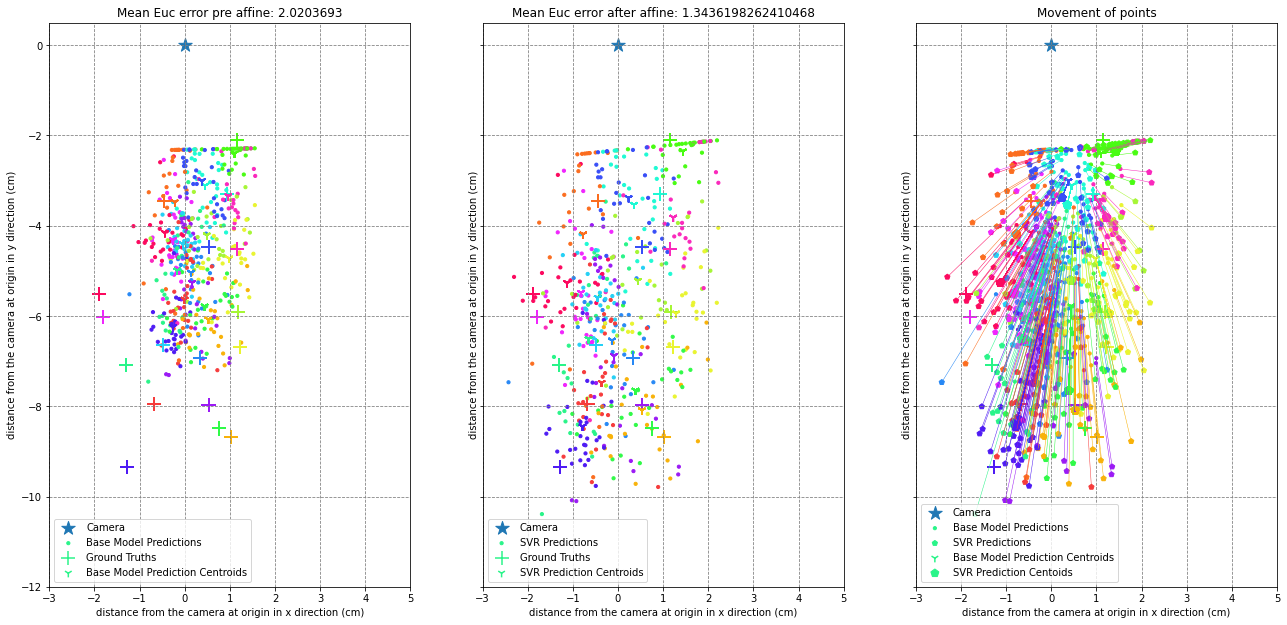

 90%|█████████ | 9/10 [00:14<00:01,  1.76s/it]

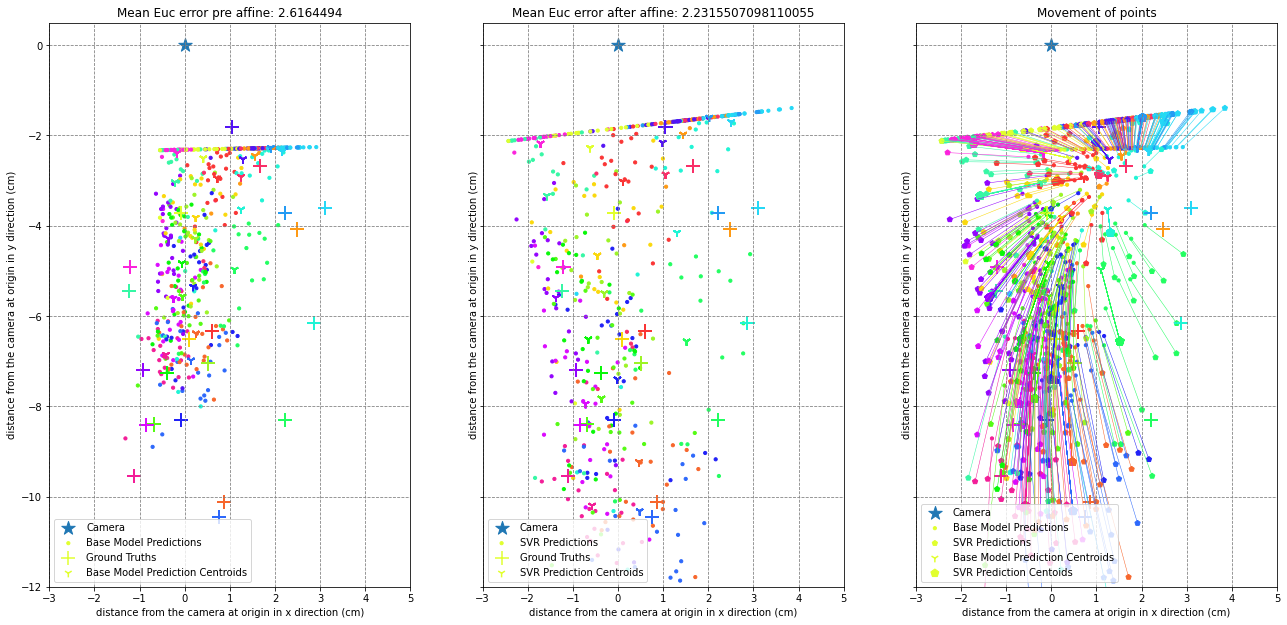

100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


In [ ]:
for i in tqdm(list(affine_out.keys())[:10]):
    plot_comp(affine_out[i][2], affine_out[i][3], affine_out[i][4], affine_out[i][5], affine_out[i][6], ['Mean Euc error pre affine: '+str(np.mean(affine_out[i][0])), 'Mean Euc error after affine: '+str(np.mean(affine_out[i][1]))], cent='both', lines=True)